In [1]:
from keras.models import load_model
import tensorflow as tf

Using TensorFlow backend.


In [2]:
model = load_model("alzheimers_model.hdf5")

# Model to TFLite

In [3]:
TFLITE_MODEL = "converted_model.tflite"

In [ ]:
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Load TFLite model

In [4]:
tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [  1 150 150   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1 3]
type: <class 'numpy.float32'>


# Load Test Data

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from keras.preprocessing import image

In [6]:
p_test = Path("./alzheimers_dataset/test")

dirsr = p_test.glob("*")

test_image_data = []
test_label_data = []
sum_test = 0
for folder_path in dirsr :
    label = (str(folder_path)).split("/")[-1]
    
    cnt = 0
    print("Processing ",label)
    
    for img_path in folder_path.glob("*.jpg"):
        img = image.load_img(img_path,target_size=(150,150))
        img_array = image.img_to_array(img)
        
        test_image_data.append(img_array)
        test_label_data.append(label)
        
        cnt += 1
        
    print("Number of images: ",cnt)
    sum_test +=cnt
    
print("Total Number of images: ",sum_test)

Processing  NonDemented
Number of images:  512
Processing  VeryMildDemented
Number of images:  358
Processing  MildDemented
Number of images:  143
Total Number of images:  1013


In [7]:
label_dict = {}

cnt = 0
for labels in np.unique(test_label_data):
    label_dict[labels] = cnt
    cnt +=1
    
label_dict.items()

dict_items([('MildDemented', 0), ('NonDemented', 1), ('VeryMildDemented', 2)])

In [8]:
for i in range(len(test_label_data)):
    test_label_data[i] = label_dict[test_label_data[i]]

In [9]:
reverse_dict = dict((value,key) for (key,value) in label_dict.items())
reverse_dict.items()

dict_items([(0, 'MildDemented'), (1, 'NonDemented'), (2, 'VeryMildDemented')])

In [10]:
Xtest = np.array(test_image_data)/255.0
Ytest = np.array(test_label_data).astype('float32')

print(Xtest.shape)
print(Ytest.shape)

(1013, 150, 150, 3)
(1013,)


# Visualize Test Data

In [11]:
def drawImg(img,label):
    plt.style.use("seaborn")
    plt.title(reverse_dict[label])
    plt.axis("off")
    plt.imshow(img)
    plt.show()

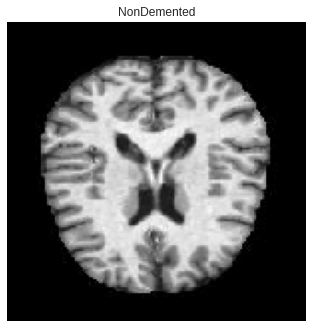

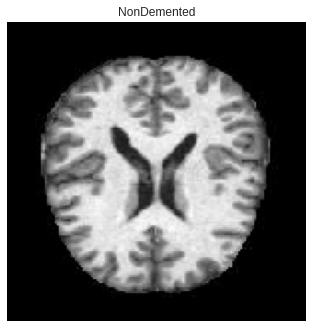

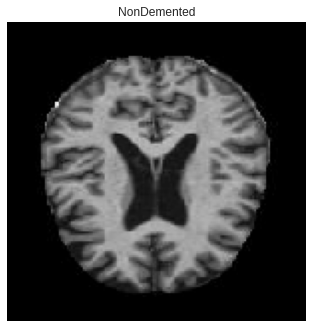

In [12]:
for i in range(3):
    r = np.random.randint(len(Xtest))
    drawImg(Xtest[r],Ytest[r])

# Change Batch-Size of TFLite Model

In [13]:
tflite_interpreter.resize_tensor_input(input_details[0]['index'], (sum_test, 150, 150, 3))
tflite_interpreter.resize_tensor_input(output_details[0]['index'], (sum_test, 3))
tflite_interpreter.allocate_tensors()

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [1013  150  150    3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [1013    3]
type: <class 'numpy.float32'>


# Get Predictions

In [14]:
tflite_interpreter.set_tensor(input_details[0]['index'], Xtest)

In [15]:
tflite_interpreter.invoke()

In [16]:
tflite_model_predictions = tflite_interpreter.get_tensor(output_details[0]['index'])
print("Prediction results shape:", tflite_model_predictions.shape)

Prediction results shape: (1013, 3)


In [17]:
import pandas as pd

In [18]:
tflite_pred_dataframe = pd.DataFrame(tflite_model_predictions)
tflite_pred_dataframe.columns = label_dict.keys()

print("TFLite prediction results for the first elements")
tflite_pred_dataframe.head()

TFLite prediction results for the first elements


,MildDemented,NonDemented,VeryMildDemented
0,0.000003,0.881935,0.232777
1,0.052574,0.100776,0.484598
2,0.555599,0.358405,0.591339
3,0.337038,0.419323,0.580077
4,0.531690,0.392276,0.569271


# Precision-Recall

In [19]:
result = np.zeros((tflite_model_predictions.shape[0]))
for i in range(tflite_model_predictions.shape[0]):
    result[i] = np.argmax(tflite_model_predictions[i])

In [22]:
from sklearn.metrics import classification_report,confusion_matrix

In [23]:
print(classification_report(result,Ytest))

              precision    recall  f1-score   support

         0.0       0.34      0.69      0.46        71
         1.0       0.60      0.74      0.66       416
         2.0       0.71      0.48      0.58       526

    accuracy                           0.60      1013
   macro avg       0.55      0.64      0.57      1013
weighted avg       0.64      0.60      0.60      1013



# Confusion-Matrix

In [24]:
cnf_matrix = confusion_matrix(result,Ytest)
print(cnf_matrix)

[[ 49   9  13]
 [ 18 308  90]
 [ 76 195 255]]
